# Second Project

In this project, you will implement a debugging reducer able to reduce a Python program containing a specific property down to a syntactically correct Python program that *only* contains said property.
To do this, you will be given several Python parsers checking for specific properties as well as Python programs containing these properties.

The time frame for this project is **2 weeks**, and the Deadline is **January 15th 23:59**.

In [1]:
import bookutils.setup

In [2]:
import inspect
import ast

In [3]:
from bookutils import show_ast

In [4]:
from ExpectError import ExpectError

In [5]:
# ignore
from typing import Any, Optional, Set, cast

## Description

Imagine we want to create a new compiler for Python programs which transforms the code into a binary executable.
To this end, at first we need to implement a parser that parses a given program into a set of individual statements which can then be converted to the bytecode.

### Parsing Python  

If we want to parse a programming language like Python, it makes sense to parse the code into an abstract syntax tree (AST) and work with the AST from this point onward.
The reason we might want to do this, is to preserve the syntactic integrity of our program.
Let's start with parsing a simple Python function (`foo`) into an AST using `ast.parse()` and printing it.

In [6]:
def foo(a, b):    # type: ignore
    """
    Checks whether a and b are true
    """
    if a and b:
        return 1
    return 0

We take a string representation of `foo()`...

In [7]:
source = inspect.getsource(foo)

In [8]:
print(source)

def foo(a, b):    # type: ignore
    """
    Checks whether a and b are true
    """
    if a and b:
        return 1
    return 0



...and convert it to the AST:

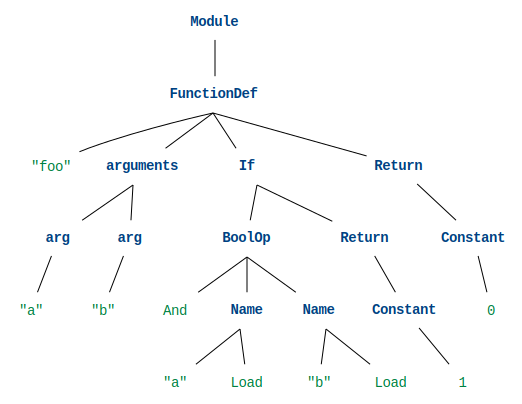

In [9]:
source_ast = ast.parse(source)
show_ast(source_ast)

We can see how the code is structured by inspecting the AST shown above.

To learn the structure of an AST, have a look at the [official Python `ast` reference](http://docs.python.org/3/library/ast) for a list of AST nodes and their attributes.
This reference is complete, but a bit terse; the ["Green Tree Snakes missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/manipulating.html) provide a good manual on how to modify the tree.

If we want to inspect certain elements of the source code, we can now use the `ast.NodeVisitor` to visit every node in the AST.
This can be done by extending this class and implementing *visit-methods* for each type of node in the tree we want to inspect.  
So, let's implement a parser that first parses the source code into an AST and then visits each node one after another.

In [10]:
class SimpleParser(ast.NodeVisitor):
    """
    A simple parser printing all nodes in order
    """

    def parse(self, file: str) -> None:
        """
        When the parse function is called, we parse the source code
        into a tree and then start visiting all nodes.
        """
        tree = ast.parse(source=file)
        self.visit(tree)

    def visit_FunctionDef(self, node: ast.FunctionDef) -> None:
        print(node)
        self.generic_visit(node)

    def visit_arguments(self, node: ast.arguments) -> None:
        print(node)
        self.generic_visit(node)

    def visit_If(self, node: ast.If) -> None:
        print(node)
        self.generic_visit(node)

    def visit_Return(self, node: ast.Return) -> None:
        print(node)
        self.generic_visit(node)

    def visit_arg(self, node: ast.arg) -> None:
        print(node)
        self.generic_visit(node)

    def visit_Constant(self, node: ast.Constant) -> None:
        print(node)
        self.generic_visit(node)

    def visit_Name(self, node: ast.Name) -> None:
        print(node)
        self.generic_visit(node)

    def visit_BoolOp(self, node: ast.BoolOp) -> None:
        print(node)
        self.generic_visit(node)

Using this `SimpleParser`, we can visit each node and print the node object itself.

In [11]:
SimpleParser().parse(source)

Now imagine, instead of just parsing the input and printing each node, we start to process the information present in each node.
To notify the user if anything breaks, we introduce a `ParserException` that is thrown when we encounter a parsing error.

In [12]:
class ParserException(Exception):
    pass

For instance, let's consider our parser has troubles processing boolean operators.
We simulate this behavior by extending our parser to throw an exception whenever it encounters a `BoolOp` node.


In [13]:
class SimpleParserPlus(SimpleParser):
    """
    A simple parser printing all nodes in order until it reaches a BoolOp
    """

    def visit_BoolOp(self, node: ast.BoolOp) -> None:
        """
        If a BoolOp is encountered, we throw an exception
        """
        raise ParserException("Something went wrong")

In [14]:
with ExpectError():
    SimpleParserPlus().parse(source)


Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/257518062.py", line 2, in <cell line: 1>
    SimpleParserPlus().parse(source)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/2922974276.py", line 12, in parse
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/2922974276.py", line 16, in visit_FunctionDef
    self.generic_visit(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in

As we can see here, as soon as we encounter a boolean operation, an exception is thrown.

### Reducing Python

Let's get back to our `SimpleParserPlus` example. This parser parses Python code into an AST and then iterates over all nodes. When it reaches a boolean operation, it encounters an error and crashes.  
Of course our example is a very small and artificial one. Furthermore, the input triggering our bug is rather small as well.
However, in reality a similar situation might present itself to you but with a far less obvious error and a far larger input that causes it.
In this case, instead of using the entire input, one might want to reduce the input down to only those parts actually causing the error.  
But how do we do that?  
We could, for instance, randomly remove some parts of the program.
However, this would likely produce syntactically invalid Python code and hence prevent the parser from reaching the desired code location.
So instead of just removing random parts of the code itself, we will manipulate the AST to preserve the correct syntax.

How do we manipulate an AST produced by `ast.parse`? We can make use of the `ast.NodeTransformer`:

In [15]:
class NodeReducer(ast.NodeTransformer):

    def visit_If(self, node: ast.If) -> ast.AST:
        """
        Instead of the `if` node return just its condition
        """
        # Apply other transformations to the children first
        super().generic_visit(node)

        # We create an expression around the node test
        new_node = ast.Expr(node.test)
        return new_node

The `ast.NodeTransformer` again uses the visitor pattern to walk over all nodes.
This time, however, we change the resulting AST. In our case, if we encounter an *if-statement* we only return the condition.   

(Keep in mind, `NodeReducer` changes the ast in place, so if you want to preserve the original tree, you need to copy it with `copy.deepcopy(tree)`)

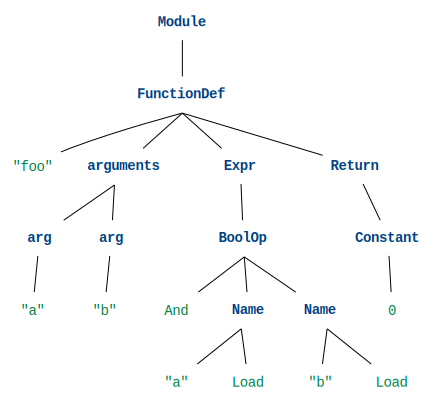

In [16]:
NodeReducer().visit(source_ast)
show_ast(source_ast)

As you can see, after running the `NodeReducer` there is no longer an *if-statement*, but only its condition.
A more sophisticated NodeReducer is presented in the [Reducing Failure-Inducing Inputs chapter](https://www.debuggingbook.org/beta/html/DeltaDebugger.html) in the debugging book.

To learn the structure of an AST, have a look at the [official Python `ast` reference](http://docs.python.org/3/library/ast) for a list of AST nodes and their attributes. This reference is complete, but a bit terse; the ["Green Tree Snakes missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/manipulating.html) provide a good manual on how to modify the tree.

**Pro tip**: You can learn the expected structure of any Python fragment by invoking `ast.dump()` on any (parsed) AST.

In [17]:
demo_ast = ast.parse('''
if a == b:
    c = d
''')

In [18]:
print(ast.dump(demo_ast, indent=4))

Module(
    body=[
        If(
            test=Compare(
                left=Name(id='a', ctx=Load()),
                ops=[
                    Eq()],
                comparators=[
                    Name(id='b', ctx=Load())]),
            body=[
                Assign(
                    targets=[
                        Name(id='c', ctx=Store())],
                    value=Name(id='d', ctx=Load()))],
            orelse=[])],
    type_ignores=[])


The nice thing is that this not only reveals the AST structure, it also tells you how to construct it. If you take the very structure as produced by `ast.dump()` and evaluate it, you obtain the same syntax tree.

In [19]:
from ast import Module, If, Compare, Load, Eq, Assign, Name, Store

In [20]:
ast_from_scratch = Module(
    body=[
        If(
            test=Compare(
                left=Name(id='a', ctx=Load()),
                ops=[
                    Eq()],
                comparators=[
                    Name(id='b', ctx=Load())]),
            body=[
                Assign(
                    targets=[
                        Name(id='c', ctx=Store())],
                    value=Name(id='d', ctx=Load()))],
            orelse=[])],
    type_ignores=[])

You need to invoke `ast.fix_missing_locations()` to add line numbers and other location info that would be normally added during parsing...

In [21]:
ast_from_scratch = ast.fix_missing_locations(ast_from_scratch)

... and with this, you're all set:

In [22]:
print(ast.unparse(ast_from_scratch))

if a == b:
    c = d


Hence, if you do not know what kind of AST fragment to produce, just
1. parse its text with ``ast.parse()`` 
2. study the expression produced by `ast.dump()`, and
3. build it from the same expression, using `ast.fix_missing_locations()` and `ast.unparse()`

### Implementing a Reducing Debugger

Having seen how one can access and transform AST structures using a `NodeReducer` in Python, we can now use that knowledge to implement a `ReducingDebugger`
capable of reducing the failure inducing Python code down to only that parts of the code that actually triggers the failure.

In [23]:
class ReducingDebugger:
    def __init__(self, parser: SimpleParser) -> None:
        """
        We initialize the DebuggingReducer with a parser,
        as this is needed to verify whether the failure 
        is still triggered after the code transformation
        """
        self.parser = parser
        self.node_reducer = NodeReducer()

    def minimize(self, code: str) -> str:
        """
        This function takes some Python code as string, reduces
        it using the NodeReducer defined earlier and returns the 
        reduced program.
        """
        # Parse the code to a tree
        code_ast = ast.parse(source=code)

        # Use the visit-method of the NodeReducer to reduce if nodes down to their condition
        new_code_ast = self.node_reducer.visit(code_ast)

        # After we've updated nodes, we need to fix the tree
        ast.fix_missing_locations(new_code_ast)

        # Generate code from the reduced tree
        new_code = ast.unparse(new_code_ast)

        # Test, whether the error is still triggered by the reduced code
        try:
            self.parser.parse(new_code)
            # No exception is thrown. This means the new_code does not 
            # trigger an error anymore. Therefore, we failed in
            # reduction and return the initial code.
            return code
        except ParserException:
            # The error is still triggered. Return the reduced code
            return new_code

The `ReducingDebugger` implemented above takes some Python code as an input and replaces all if-statements with their conditions.
Then, it checks whether the newly generated code still triggers the error. If not, it returns the initial code. If the exception is still triggered, it returns the reduced code.
Let's apply it to the source code of our `foo` function:

In [24]:
reducing_debugger = ReducingDebugger(SimpleParserPlus())
new_source = reducing_debugger.minimize(source)

In [25]:
print(new_source)

def foo(a, b):
    """
    Checks whether a and b are true
    """
    a and b
    return 0


In [26]:
with ExpectError():
    SimpleParserPlus().parse(new_source)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/3561000985.py", line 2, in <cell line: 1>
    SimpleParserPlus().parse(new_source)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/2922974276.py", line 12, in parse
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/2922974276.py", line 16, in visit_FunctionDef
    self.generic_visit(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 41

As we can see, our `ReducingDebugger` reduces the original function to a smaller input, while still preserving the property of the code that triggers the same error as before.
However, this reducer is very simple: it applies only one transformation to all `if` nodes at once.
Instead, one can consider various transformations of the same node as well as transformations of various node types and apply them one by one (or in batches) to gradually reduce the code.

Keep in mind, that the changes should be made in a way that the code is still accepted by a regular Python interpreter.
Besides, the goal is to obtain a minimal program that still triggers the error.
So, your debugging reducer should not simply reduce all possible nodes, but also regularly check whether the reduced code still triggers the failure.

Therefore, you are required to implement certain modifications that can be done to the AST. In general, these transformations can be one of the following:   

1. Delete a node,
2. Substitute a node with the new node (e.g., _pass_ node),
3. Substitute a node with all of its children,
4. Substitute a node with one of its children.

More detailed, one can consider, for instance:

1. Replacing a `BoolOp` node by `True`.
2. Replacing a `BoolOp` node by `False`.
3. Replacing a `BoolOp` node by its left operand.
4. Replacing a `BoolOp` node by its right operand.
5. Replacing an `If` node by its "then" body.
6. Replacing an `If` node by its condition.
7. Replacing an `If` node by its "else" body.
8. Replacing all instances of a variable by a constant.
9. Replacing expressions by a constant.
10. etc.

Please, refer to the [official Python `ast` reference](http://docs.python.org/3/library/ast) for a full list of node types.

## Implementation

To succeed in this project, you need to complete the `MyReducer` class.

In [27]:
class MyReducer(ReducingDebugger):

    def minimize(self, code: str) -> str:
        # TODO: implement this!
        return code

To this end, you will need to extend the `NodeReducer` with additional transformations and implement a reducer strategy
which collects all possible transformations and applies them to the AST until it is exhaustively minimized.
Feel free to make your own implementation or extend the `DeltaDebugger` from the [Reducing Failure-Inducing Inputs chapter](https://www.debuggingbook.org/beta/html/DeltaDebugger.html) with
the proper strategy.

## Evaluation

We evaluate your project based on public as well as secret tests. In this section, we present **five** different Python parsers as well as **five** Python input programs, which should be minified.
These parsers check for a specific property in the code and fail the execution if the property exists. The input programs and parsers in this section make up the public test cases.
If you pass all of those tests **without hardcoding the modifications** you are guaranteed to score 15 points in this project. You can get more points for passing secret tests.

### Parsers

In [28]:
class Parser(ast.NodeVisitor):
    """The base class for a parser"""

    def parse_tree(self, tree: ast.AST) -> None:
        self.visit(tree)

    def parse(self, source: str) -> str:
        tree = ast.parse(source=source)
        self.parse_tree(tree)
        return "The input was successfully parsed."

`Parser` is the base class for a parser from which all other parsers are derived. It works the same way as the `SimpleParser` introduced earlier.

Let's define a couple of parsers which model a failure during processing of a certain code feature.

In [29]:
class Parser1(Parser):
    """
    Contains a boolean operation
    """

    def visit_BoolOp(self, node: ast.BoolOp) -> None:
        raise ParserException(f"Something went wrong")

If we feed this parser with an input program which contains a boolean operation, it fails:

In [30]:
parser1 = Parser1()
input_program = '''
a = True and False'''
with ExpectError():
    parser1.parse(input_program)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/2806337694.py", line 5, in <cell line: 4>
    parser1.parse(input_program)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 9, in parse
    self.parse_tree(tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 5, in parse_tree
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 420, in generic_visit
    self.visit(value)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    ret

In contrast to the above, an input program _without_ a boolean operation is parsed correctly.

In [31]:
parser1 = Parser1()
input_program = '''
a = 1
b = True
'''

parser1.parse(input_program)

'The input was successfully parsed.'

The other parsers are

In [32]:
class Parser2(Parser):
    """
    Fails if an input program contains `if` statement
    """
    def visit_If(self, node: ast.If) -> None:
        raise ParserException(f"Something went wrong")

In [33]:
parser2 = Parser2()
input_program = '''
if a:
    b = 1
else:
    b = 2
'''
with ExpectError():
    parser2.parse(input_program)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1476831468.py", line 9, in <cell line: 8>
    parser2.parse(input_program)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 9, in parse
    self.parse_tree(tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 5, in parse_tree
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1684278366.py", line 6, in visit_If
    raise ParserException(f"Something went wrong")
ParserException: Something went wrong (expected)


In [34]:
class Parser3(Parser):
    """
    Fails if an input program contains a special unicode character
    """

    def __init__(self) -> None:
        self.assignment = False
        self.steps = 0

    def check_unicode(self, string: str) -> bool:
        return string == u'\u0426'

    def generic_visit(self, node: ast.AST) -> None:
        self.steps += 1
        super().generic_visit(node)

    def visit_Assign(self, node: ast.Assign) -> None:
        self.assignment = True
        self.steps = 0
        self.generic_visit(node)

    def visit_Constant(self, node: ast.Constant) -> None:
        if self.assignment and self.steps == 3:
            if isinstance(node.value, str):
                if self.check_unicode(node.value):
                    raise ParserException(f"Something went wrong")

In [35]:
parser3 = Parser3()
input_program = '''
a = u'\u0426'
'''
with ExpectError(ParserException):
    parser3.parse(input_program)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/951683174.py", line 6, in <cell line: 5>
    parser3.parse(input_program)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 9, in parse
    self.parse_tree(tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 5, in parse_tree
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/2904791116.py", line 15, in generic_visit
    super().generic_visit(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1

In [36]:
class Parser4(Parser):
    """
    Fails if an input program contains a variable which is not defined
    """

    def __init__(self) -> None:
        self.assignment = False
        self.steps = 0
        self.variables: Set[str] = set()

    def generic_visit(self, node: ast.AST) -> None:
        self.steps += 1
        super().generic_visit(node)

    def visit_Name(self, node: ast.Name) -> None:
        if self.assignment and self.steps == 1:
            self.variables.add(node.id)
            self.assignment = False
            self.generic_visit(node)
        elif node.id in self.variables:
            self.generic_visit(node)
        else:
            raise ParserException(f"Something went wrong")

    def visit_Assign(self, node: ast.Assign) -> None:
        self.assignment = True
        self.steps = 0
        self.generic_visit(node)

In [37]:
parser4 = Parser4()
input_program = '''
a = 1
b = c
'''
with ExpectError(ParserException):
    parser4.parse(input_program)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1261297070.py", line 7, in <cell line: 6>
    parser4.parse(input_program)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 9, in parse
    self.parse_tree(tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 5, in parse_tree
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/3413124393.py", line 13, in generic_visit
    super().generic_visit(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_

In [38]:
class Parser5(Parser):
    """
    Fails if an input program contains a list
    """

    def visit_List(self, node: ast.List) -> None:
        raise ParserException(f"Something went wrong") 

In [39]:
parser5 = Parser5()
input_program = '''
a = {x * 2 for x in map(int, ['1', '2', '3'])}
'''
with ExpectError(ParserException):
    parser5.parse(input_program)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/3158638464.py", line 6, in <cell line: 5>
    parser5.parse(input_program)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 9, in parse
    self.parse_tree(tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 5, in parse_tree
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 420, in generic_visit
    self.visit(value)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    ret

For secret tests we may use other parsers crafted in the same way.

### Input Programs

Now we present five public tests.
Each test case implements a `get_original()` method that returns an input program which your reducer should minify.
It also has a `parser` field which stores a parser used for a respective input program.
Besides, `get_minimized()` method provides a reference solution.

In [40]:
class Test1:
    parser = Parser1()

    def get_original(self) -> str:
        return '''
def original():
    a = True
    b = not False
    c = 30
    for i in range(c):
        if i == 15:
            if a and b:
                return 1
    return 0
'''

    def get_minimized(self) -> str:
        return '''
True and True'''

In [41]:
class Test2:
    parser = Parser2()
    def get_original(self) -> str:
        return '''
def original():
    a = True
    b = not False
    c = 30
    for i in range(c):
        if i == 15:
            if a and b:
                return 1
    return 0
    '''

    def get_minimized(self) -> str:
        return '''
if True:
    return
'''

In [42]:
class Test3:
    parser = Parser3()
    def get_original(self) -> str:
        return '''
def original():
    a = 1
    b = a
    c = a - b
    if c < a:
        d = ''
        while a == b:
            d = u'\u0426'
            a += 1
        return d
    return ''
'''

    def get_minimized(self) -> str:
        return '''
d = u'\u0426'
'''

In [43]:
class Test4:
    parser = Parser4()
    def get_original(self) -> str:
        return '''
def original():
    a = 1
    b = a
    c = a - b
    if c < a:
        while a == b:
            a += 1
        return d
    return ''
'''

    def get_minimized(self) -> str:
        return '''
d
'''

In [44]:
class Test5:
    parser = Parser5()

    def get_original(self) -> str:
        return '''
def original():
    a = 1
    b = 0
    while True:
        if a < b:
            return [1, 2, 3]
        else:
            return []
'''

    def get_minimized(self) -> str:
        return '''
[]
'''

For instance, let's take the input program of `Test1`:

In [45]:
test = Test1()
source = test.get_original()
print(source)


def original():
    a = True
    b = not False
    c = 30
    for i in range(c):
        if i == 15:
            if a and b:
                return 1
    return 0



And parse it with the provided parser:

In [46]:
with ExpectError():
    test.parser.parse(source)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1292946598.py", line 2, in <cell line: 1>
    test.parser.parse(source)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 9, in parse
    self.parse_tree(tree)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_1505/1737200860.py", line 5, in parse_tree
    self.visit(tree)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return visitor(node)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 418, in generic_visit
    self.visit(item)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/ast.py", line 410, in visit
    return 

The parser failed.

### Testing Infrastructure

The following section introduces the testing infrastructure, which is used to assess your performance in the project. Passing all tests will be enough to complete the project successfully.

We are not going to directly compare a minimized program with the reference solution (as two strings). Instead, we again transform the code into AST and count the number of nodes in both trees.
If the difference between them is lower than a `THRESHOLD` (and a parser still produces an error), the test is passed.
To count the number of nodes in the AST, we need a helper class `NodeCounter`.

In [47]:
class NodeCounter(ast.NodeVisitor):
    """
    This node counter is used to assess
    the amount of reductions performed by your reducer.
    It counts the number of nodes in the AST.
    """

    def __init__(self) -> None:
        self.num_nodes = 0

    def visit(self, node: ast.AST) -> None:
        self.num_nodes += 1
        self.generic_visit(node)

    def count(self, source: str) -> int:
        tree = ast.parse(source=source)
        self.visit(tree)
        return self.num_nodes

The AST of the input program is as follows:

In [48]:
show_ast(ast.parse(source))
print(f"The number of nodes is {NodeCounter().count(source)}")

The number of nodes is 42


As you can see, the input program of `Test1` has 42 nodes.

The testing framework takes a reducer and allows executing a single test or all tests at once.

In [49]:
class TestingFramework:
    THRESHOLD = 3
    test_cases = {
        'test1': Test1(),
        'test2': Test2(),
        'test3': Test3(),
        'test4': Test4(),
        'test5': Test5()
    }

    def __init__(self, reducer: Any) -> None:
        self.reducer = reducer

    def count_nodes(self, source: Optional[str]) -> int:
        if source is None:
            return 100000
        return NodeCounter().count(source)

    def run_test(self, test: Any) -> bool:
        """
        run a single test
        """
        print(f'Running test {test.__class__.__name__}')
        reducer = self.reducer(test.parser)
        reduced_code = reducer.minimize(test.get_original())
        return (self.has_property(reduced_code, test.parser) and 
                self.is_minimized(reduced_code, test.get_minimized()))

    def run_tests(self) -> None:
        """
        run all public tests
        """
        passed_tests = 0
        for test in self.test_cases.values():
            success = self.run_test(test)
            if success:
                passed_tests += 1

        print(f"In total {passed_tests} tests passed")

    def has_property(self, source: str, parser: Any) -> bool:
        """returns True if the parser fails to parse the source"""
        try:
            parser.parse(source)
            print(f'HAS PROPERTY: FAIL')
            return False
        except ParserException:
            print(f'HAS PROPERTY: OK')
            return True
        except Exception as e:
            print(f'HAS PROPERTY: FAIL {e}')
            return False

    def is_minimized(self, reduced: str, reference: str) -> bool:
        """
        Returns True if the AST of the reduced code contains 
        no more then the number of nodes in the reference + a THRESHOLD
        """
        count_minimized = self.count_nodes(reduced)
        count_reference = self.count_nodes(reference)
        if count_minimized <= count_reference + self.THRESHOLD:
            print(f'IS MINIMIZED: OK')
            return True
        else:
            print(f'IS MINIMIZED: FAIL')
            return False

Let's test our `ReducingDebugger` with the following test:

In [50]:
class Test0:
    parser = Parser1()

    def get_original(self) -> str:
        return '''
if a and b:
    c = 1
else:
    c = 2
'''

    def get_minimized(self) -> str:
        return '''
a and b'''

In [51]:
tf = TestingFramework(ReducingDebugger)
if tf.run_test(Test0()):
    print("Success!")

Running test Test0
HAS PROPERTY: OK
IS MINIMIZED: OK
Success!


The input program was successfully minimized.

What if we run all public tests?

In [52]:
tf.run_tests()

Running test Test1
HAS PROPERTY: OK
IS MINIMIZED: FAIL
Running test Test2
HAS PROPERTY: OK
IS MINIMIZED: FAIL
Running test Test3
HAS PROPERTY: OK
IS MINIMIZED: FAIL
Running test Test4
HAS PROPERTY: OK
IS MINIMIZED: FAIL
Running test Test5
HAS PROPERTY: OK
IS MINIMIZED: FAIL
In total 0 tests passed


Unfortunately, our parser failed to minimize all input programs from the public test suite.

## Grading

For this project, you can get a total of 30 Points:

* 15 Points will be awarded for passing the public test (**without hardcoding the minimized solution or the sequence of transformations**) presented in this notebook.
These 15 points mean that you successfully implemented the must-have implementation.
* 5 Points will be awarded for passing secret tests.
* 10 Points will be awarded for efficient implementation (see may-have implementation).

### Must-have Features

Implement a reducer which minifies a given program so that its parser still produces an error.
To this end, collect all possible transformations over the nodes of an AST tree and then apply one change at a time.
These modifications should be repeated until no further updates can be made without triggering a parser exception.
If your reducer passes secret test you are awarded additional 5 points.

*Note: Implementing the given modifications should be sufficient to successfully complete this project.*

### May-have Features

An implementation only of the must-have features aims for correctness but can be inefficient (if transformations are applied one at a time). So, it can be optimized, for instance, with help of the Delta Debugging approach.

Implement an AST Delta Debugger which efficiently prunes the nodes.
If your reducer can beat the runtime of our reference implementation (which simply collects all possible transformations and applies them randomly one at a time) you can get up to 10 points (depending on the margin).

Hint: The [Reducing Failure-Inducing Inputs chapter](https://www.debuggingbook.org/beta/html/DeltaDebugger.html) already tries to optimize the reduction of the AST with help of Delta Debugging.  
Hint: For instance, you can find useful _Hierarchical Delta Debugging_ paper from the Background section of **Reducing Failure-Inducing Inputs** Chapter.